#data initialization
####moduled for rdsf_v2.csv
####initializes by pip installing
####imports dependencies and dataset
####reformats data

##config
##mount drive, pip install, import

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
#requirements

#!pip install xgboost
#!pip install shap
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install matplotlib
!pip install graphviz

In [229]:
import shap
import itertools
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.callback import EarlyStopping
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, matthews_corrcoef
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## Importing the data
##### Loading the dataset rdsort_data.csv from the drive.
####Reformat gender, insurance, language to numbers


In [230]:
#read data
#in google drive upload the data csv file ready (important name it accordingly)
#if not it file open the taskbar to the left, then mount google drive

adf = pd.read_csv('/content/drive/MyDrive/dataset/rdsf_v2.csv')

Reformat gender, insurance, language objects to numbers

In [231]:
# Ensure consistent casing in the insurance column
if 'insurance' in adf.columns:
    adf['insurance'] = adf['insurance'].astype(str).str.lower()  # Convert all values to strings and lowercase
    adf['insurance'] = adf['insurance'].replace({'medicare': 3, 'medicaid': 2, 'other': 1})
    adf['insurance'] = pd.to_numeric(adf['insurance'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    adf['insurance'] = adf['insurance'].fillna(0).astype(int)  # Fill NaNs with a default value and convert to integer

# Ensure gender column is properly mapped and converted
if 'gender' in adf.columns:
    adf['gender'] = adf['gender'].astype(str).str.lower()  # Convert all values to strings and lowercase
    adf['gender'] = adf['gender'].replace({'m': 2, 'f': 1})
    adf['gender'] = pd.to_numeric(adf['gender'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    adf['gender'] = adf['gender'].fillna(0).astype(int)  # Fill NaNs with a default value and convert to integer

# Ensure language column is properly mapped and converted
if 'language' in adf.columns:
    adf['language'] = adf['language'].astype(str).str.lower()  # Convert all values to strings and lowercase
    adf['language'] = adf['language'].replace({'english': 2, '?': 1, 'n/a': 0})
    adf['language'] = pd.to_numeric(adf['language'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    adf['language'] = adf['language'].fillna(0).astype(int)  # Fill NaNs with a default value and convert to integer

# Ensure race column is properly mapped and grouped
if 'race' in adf.columns:
    # Convert all values to strings and lowercase for consistency
    adf['race'] = adf['race'].astype(str).str.lower()

    # Define race groups
    race_group_mapping = {
        # White group
        'white': 1, 'white - brazilian': 1, 'white - eastern european': 1,
        'white - other european': 1, 'white - russian': 1,

        # Asian group
        'asian': 2, 'asian - asian indian': 2, 'asian - chinese': 2,
        'asian - korean': 2, 'asian - south east asian': 2,

        # Black group
        'black/african': 3, 'black/african american': 3, 'black/cape verdean': 3,
        'black/caribbean island': 3,

        # Latino group
        'hispanic or latino': 4, 'hispanic/latino - central american': 4,
        'hispanic/latino - columbian': 4, 'hispanic/latino - cuban': 4,
        'hispanic/latino - dominican': 4, 'hispanic/latino - guatemalan': 4,
        'hispanic/latino - honduran': 4, 'hispanic/latino - mexican': 4,
        'hispanic/latino - puerto rican': 4, 'hispanic/latino - salvadoran': 4,
        'south american': 4, 'portuguese': 4,

        # Islander group
        'native hawaiian or other pacific islander': 5,

        # Native group
        'american indian/alaska native': 6,

        # Other group
        'multiple race/ethnicity': 7, 'other': 7,

        # Unspecified or Declined
        'patient declined to answer': 0, 'unable to obtain': 0, 'unknown': 0, 'n/a': 0
    }

    # Apply mapping
    adf['race'] = adf['race'].replace(race_group_mapping)

    # Convert to numeric, handling any unexpected values as NaN
    adf['race'] = pd.to_numeric(adf['race'], errors='coerce')

    # Fill NaN values with 0 and convert to integer type
    adf['race'] = adf['race'].fillna(0).astype(int)

# Ensure sepsis3 column is properly mapped to binary values
if 'sepsis3' in adf.columns:
    # Convert the column: True -> 1, missing/NaN -> 0
    adf['sepsis3'] = adf['sepsis3'].notna().astype(int)

<ipython-input-231-6b42cd451f29>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adf['insurance'] = adf['insurance'].replace({'medicare': 3, 'medicaid': 2, 'other': 1})
<ipython-input-231-6b42cd451f29>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adf['gender'] = adf['gender'].replace({'m': 2, 'f': 1})
<ipython-input-231-6b42cd451f29>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt

##### Looking at the first five rows

In [232]:
# Check the size of the dataframe
print(f"Shape :{adf.shape}")
# Check the columns
print(f"Columns: {adf.columns}")

Shape :(23090, 70)
Columns: Index(['subject_id', 'stay_id', 'antibiotic_time', 'culture_time',
       'suspected_infection_time', 'sofa_time', 'sofa_score', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal', 'sepsis3',
       'rn', 'intime', 'outtime', 'icu_hours', 'dod', 'st48h', 'st90d',
       'stinhosp', 'age', 'weight', 'gender', 'language', 'insurance', 'race',
       'gcs', 'heart_rate', 'sbp', 'dbp', 'body_temp', 'spo2', 'resp_rate',
       'fio2', 'avg_icp', 'albumin', 'globulin', 'total_protein', 'aniongap',
       'bicarbonate_chem', 'bun', 'calcium_chem', 'chloride_chem',
       'creatinine_chem', 'glucose_chem', 'sodium_chem', 'potassium_chem',
       'magnesium_chem', 'mpv', 'pt', 'ptt', 'inr', 'bg_lactate',
       'bg_bicarbonate', 'bg_ph', 'bg_so2', 'bg_po2', 'bg_pco2',
       'bg_pao2fio2ratio', 'bg_baseexcess', 'bg_totalco2', 'hematocrit',
       'hemoglobin', 'platelet', 'wbc', 'NeuC', 'LymC', 'EoC'],
      dtype='object')


#STATISTICS
####creates adf_statistics.csv file for statistics output

In [233]:
from matplotlib.backends.backend_pdf import PdfPages

def analyze_adf_to_pdf(output_pdf="boxplots_starting.pdf"):
    """
    Computes statistics for the adf DataFrame and saves them into a single PDF file.
    Excludes specific columns (e.g., subject_id, stay_id, date columns, rn, intime, outtime)
    and counts only non-missing values in each row type.

    Args:
        output_pdf (str): The name of the output PDF file.

    Returns:
        None
    """
    global adf  # Ensure the function works with the global adf DataFrame

    if 'adf' not in globals():
        raise NameError("The 'adf' DataFrame is not defined. Please define it before running this function.")

    # Drop excluded columns
    excluded_columns = [col for col in adf.columns if "subject_id" in col.lower() or
                        "stay_id" in col.lower() or
                        "date" in col.lower() or
                        col.lower() in ["rn", "intime", "outtime", "antibiotic_time",
                                        "suspected_infection_time", "culture_time", "sofa_time", "dod"]]
    filtered_adf = adf.drop(columns=excluded_columns, errors="ignore")

    # Compute statistics
    stats_list = []
    for col in filtered_adf.columns:
        if pd.api.types.is_numeric_dtype(filtered_adf[col]):
            col_stats = {
                "Column": col,
                "Type": "Numerical",
                "Mean": round(filtered_adf[col].mean(skipna=True), 2),
                "Variance": round(filtered_adf[col].var(skipna=True), 2),
                "Std Dev": round(filtered_adf[col].std(skipna=True), 2),
                "Median": round(filtered_adf[col].median(skipna=True), 2),
                "Min": round(filtered_adf[col].min(skipna=True), 2),
                "Max": round(filtered_adf[col].max(skipna=True), 2),
                "Sum": round(filtered_adf[col].sum(skipna=True), 2),
                "Count": filtered_adf[col].notnull().sum()  # Count non-null values explicitly
            }
        else:
            # Skip categorical column statistics that are not needed
            col_stats = {
                "Column": col,
                "Type": "Categorical",
                "Mean": None,
                "Variance": None,
                "Std Dev": None,
                "Median": None,
                "Min": None,
                "Max": None,
                "Sum": None,
                "Count": filtered_adf[col].notnull().sum()  # Count non-null values explicitly
            }

        stats_list.append(col_stats)

    # Convert statistics to a DataFrame
    stats_df = pd.DataFrame(stats_list)

    # Create PDF file
    with PdfPages(output_pdf) as pdf:
        # Add statistics as a table to the PDF
        fig, ax = plt.subplots(figsize=(12, len(stats_df) * 0.5 + 2))  # Dynamically adjust height
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=stats_df.values, colLabels=stats_df.columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(stats_df.columns))))  # Adjust column widths
        plt.title("Summary Statistics", fontsize=14, weight="bold")
        pdf.savefig(fig)
        plt.close()

        # Generate and save histograms and boxplots for numerical columns
        for col in filtered_adf.select_dtypes(include='number').columns:
            # Histogram
            fig, ax = plt.subplots(figsize=(8, 4))
            filtered_adf[col].hist(bins=20, grid=False, ax=ax)
            ax.set_title(f"Histogram of {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Frequency")
            pdf.savefig(fig)
            plt.close()

            # Boxplot
            fig, ax = plt.subplots(figsize=(8, 4))
            filtered_adf.boxplot(column=col, ax=ax)
            ax.set_title(f"Boxplot of {col}")
            ax.set_ylabel(col)
            pdf.savefig(fig)
            plt.close()

    print(f"Analysis and graphs have been saved to '{output_pdf}'.")

# Example usage
# Assuming `adf` is your DataFrame in the notebook
#analyze_adf_to_pdf()

##### We need to drop the following columns since they are irrelevant and should not be used for prediction

In [234]:
adf.drop(['subject_id', 'stay_id', 'antibiotic_time', 'culture_time',
       'suspected_infection_time', 'sofa_time', 'rn', 'intime', 'outtime','dod',
       'language', 'insurance', 'race',
          'mpv', 'bg_pao2fio2ratio'],axis=1,inplace=True)


In [235]:
adf.head()

,sofa_score,respiration,coagulation,liver,cardiovascular,cns,renal,sepsis3,icu_hours,st48h,...,bg_pco2,bg_baseexcess,bg_totalco2,hematocrit,hemoglobin,platelet,wbc,NeuC,LymC,EoC
0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1,27,1,...,48.33,0.0,27.50,34.38,12.10,141.67,8.60,72.2,NaN,NaN
1,5.0,2.0,2.0,0.0,1.0,0.0,0.0,1,101,1,...,39.67,3.0,28.33,29.50,10.73,88.00,4.73,NaN,NaN,NaN
2,3.0,0.0,0.0,0.0,0.0,3.0,0.0,1,80,1,...,69.40,13.2,43.80,35.53,11.65,198.00,15.25,93.9,NaN,NaN
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,201,1,...,48.00,7.0,34.00,25.50,8.40,302.00,7.60,NaN,NaN,NaN
4,5.0,1.0,1.0,0.0,3.0,0.0,0.0,1,26,1,...,40.17,-1.5,23.83,31.74,10.75,154.50,12.77,NaN,NaN,NaN


# Identifying missing data.
#### XGBoost has default behavior for missing data.

In [236]:
adf.dtypes

,0
sofa_score,float64
respiration,float64
coagulation,float64
liver,float64
cardiovascular,float64
cns,float64
renal,float64
sepsis3,int64
icu_hours,int64
st48h,int64


In [237]:
adf['st48h'].unique()
adf['st90d'].unique()
adf['stinhosp'].unique()

array([1, 0])

#### Handling Missing Data

#### XGBoost only allows ints, floats and boolean data types

In [238]:
def process_missing_values(adf):
    for column in adf.columns:
        # Handle numeric columns
        if pd.api.types.is_numeric_dtype(adf[column]):
            # Fill NaN values with the rounded mean
            column_mean = round(adf[column].mean(), 2)
            adf[column] = adf[column].fillna(column_mean)
            print(f"Replaced missing values in numeric column '{column}' with the rounded mean: {column_mean}")

        else:
            # Handle non-numeric columns
            if adf[column].dtype == 'object':
                # Convert empty strings or non-values to NaN
                adf[column] = adf[column].replace(['', ' '], pd.NA)

                # Convert to lowercase strings for consistency
                adf[column] = adf[column].str.lower()

                # Fill NaN with the most frequent value (mode)
                column_mode = adf[column].mode(dropna=True)
                if not column_mode.empty:
                    mode_value = column_mode[0]
                    adf[column] = adf[column].fillna(mode_value)
                    print(f"Replaced missing values in categorical column '{column}' with the mode: {mode_value}")
                else:
                    print(f"No valid mode found for column '{column}'. Skipped.")

    return adf

In [239]:
adf = process_missing_values(adf)

Replaced missing values in numeric column 'sofa_score' with the rounded mean: 3.64
Replaced missing values in numeric column 'respiration' with the rounded mean: 0.66
Replaced missing values in numeric column 'coagulation' with the rounded mean: 0.49
Replaced missing values in numeric column 'liver' with the rounded mean: 0.27
Replaced missing values in numeric column 'cardiovascular' with the rounded mean: 1.14
Replaced missing values in numeric column 'cns' with the rounded mean: 0.47
Replaced missing values in numeric column 'renal' with the rounded mean: 0.6
Replaced missing values in numeric column 'sepsis3' with the rounded mean: 0.99
Replaced missing values in numeric column 'icu_hours' with the rounded mean: 132.59
Replaced missing values in numeric column 'st48h' with the rounded mean: 0.96
Replaced missing values in numeric column 'st90d' with the rounded mean: 0.73
Replaced missing values in numeric column 'stinhosp' with the rounded mean: 0.58
Replaced missing values in num

 Splitting the data into two parts
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict

In [240]:
#check dataframe
# Check the size of the dataframe
def adfinfo(adf):
    print(f"Shape :{adf.shape}")
    # Check the columns
    print(f"Columns: {adf.columns}")
    # Check the data types
    print(f"Data types: {adf.dtypes}")
    # Check for missing values
    print(f"Missing values: {adf.isna().sum()}")
adfinfo(adf)

Shape :(23090, 55)
Columns: Index(['sofa_score', 'respiration', 'coagulation', 'liver', 'cardiovascular',
       'cns', 'renal', 'sepsis3', 'icu_hours', 'st48h', 'st90d', 'stinhosp',
       'age', 'weight', 'gender', 'gcs', 'heart_rate', 'sbp', 'dbp',
       'body_temp', 'spo2', 'resp_rate', 'fio2', 'avg_icp', 'albumin',
       'globulin', 'total_protein', 'aniongap', 'bicarbonate_chem', 'bun',
       'calcium_chem', 'chloride_chem', 'creatinine_chem', 'glucose_chem',
       'sodium_chem', 'potassium_chem', 'magnesium_chem', 'pt', 'ptt', 'inr',
       'bg_lactate', 'bg_bicarbonate', 'bg_ph', 'bg_so2', 'bg_po2', 'bg_pco2',
       'bg_baseexcess', 'bg_totalco2', 'hematocrit', 'hemoglobin', 'platelet',
       'wbc', 'NeuC', 'LymC', 'EoC'],
      dtype='object')
Data types: sofa_score          float64
respiration         float64
coagulation         float64
liver               float64
cardiovascular      float64
cns                 float64
renal               float64
sepsis3               i

#Creation of columns to make predictions

In [241]:
# columns of data used to make predictions
#remove st90d and stinhosp
X = adf.drop(['st48h', 'st90d', 'stinhosp'],axis=1)
X.head()

,sofa_score,respiration,coagulation,liver,cardiovascular,cns,renal,sepsis3,icu_hours,age,...,bg_pco2,bg_baseexcess,bg_totalco2,hematocrit,hemoglobin,platelet,wbc,NeuC,LymC,EoC
0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1,27,63,...,48.33,0.0,27.50,34.38,12.10,141.67,8.60,72.20,22.51,1.86
1,5.0,2.0,2.0,0.0,1.0,0.0,0.0,1,101,82,...,39.67,3.0,28.33,29.50,10.73,88.00,4.73,78.06,22.51,1.86
2,3.0,0.0,0.0,0.0,0.0,3.0,0.0,1,80,65,...,69.40,13.2,43.80,35.53,11.65,198.00,15.25,93.90,22.51,1.86
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,201,55,...,48.00,7.0,34.00,25.50,8.40,302.00,7.60,78.06,22.51,1.86
4,5.0,1.0,1.0,0.0,3.0,0.0,0.0,1,26,64,...,40.17,-1.5,23.83,31.74,10.75,154.50,12.77,78.06,22.51,1.86


In [242]:
# column of data to predict.
y = adf['st90d']
y.head(100)

,st90d
0,1
1,1
2,1
3,1
4,1
...,...
95,0
96,0
97,1
98,1


### Format the Data Part 2: One-Hot encoding
It is the process of converting categorical data into multiple columns of binary values
They assign numbers to categories. Think of enumarating.  Either through Column Transformer of get_dummies

In [243]:
adfinfo(X)

Shape :(23090, 52)
Columns: Index(['sofa_score', 'respiration', 'coagulation', 'liver', 'cardiovascular',
       'cns', 'renal', 'sepsis3', 'icu_hours', 'age', 'weight', 'gender',
       'gcs', 'heart_rate', 'sbp', 'dbp', 'body_temp', 'spo2', 'resp_rate',
       'fio2', 'avg_icp', 'albumin', 'globulin', 'total_protein', 'aniongap',
       'bicarbonate_chem', 'bun', 'calcium_chem', 'chloride_chem',
       'creatinine_chem', 'glucose_chem', 'sodium_chem', 'potassium_chem',
       'magnesium_chem', 'pt', 'ptt', 'inr', 'bg_lactate', 'bg_bicarbonate',
       'bg_ph', 'bg_so2', 'bg_po2', 'bg_pco2', 'bg_baseexcess', 'bg_totalco2',
       'hematocrit', 'hemoglobin', 'platelet', 'wbc', 'NeuC', 'LymC', 'EoC'],
      dtype='object')
Data types: sofa_score          float64
respiration         float64
coagulation         float64
liver               float64
cardiovascular      float64
cns                 float64
renal               float64
sepsis3               int64
icu_hours             int64
age 

In [244]:
X.dtypes

,0
sofa_score,float64
respiration,float64
coagulation,float64
liver,float64
cardiovascular,float64
cns,float64
renal,float64
sepsis3,int64
icu_hours,int64
age,int64


#ONE HOT ENCODING
#via pandas.get_dummies

In [245]:
#X_encoded = pd.get_dummies(X, columns=['sofa_score',
#       'sepsis3', 'age', 'gender', 'gcs', 'icu_hours'], dtype='int')
#X_encoded.head()

#ONE HOT ENCODING
#via scikyt-learn

In [246]:
def encode_dataset_with_onehot(data, columns_to_encode):
    from sklearn.preprocessing import OneHotEncoder

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)

    # Fit and transform the selected columns
    encoded_array = encoder.fit_transform(data[columns_to_encode])

    # Create a DataFrame for the encoded columns
    encoded_columns = encoder.get_feature_names_out(columns_to_encode)
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=data.index)

    # Drop the original columns and concatenate the encoded ones
    data_encoded = data.drop(columns=columns_to_encode)
    data_encoded = pd.concat([data_encoded, encoded_df], axis=1)

    return data_encoded

columns_to_encode = ['sofa_score', 'sepsis3', 'age', 'gender', 'gcs', 'icu_hours']
X_encoded = encode_dataset_with_onehot(X, columns_to_encode)

X_encoded.head()  # Display the transformed DataFrame

,respiration,coagulation,liver,cardiovascular,cns,renal,weight,heart_rate,sbp,dbp,...,icu_hours_1628,icu_hours_1783,icu_hours_1802,icu_hours_1855,icu_hours_1866,icu_hours_1898,icu_hours_2072,icu_hours_2185,icu_hours_2301,icu_hours_2391
0,0.0,1.0,0.0,1.0,0.0,0.0,82.10,90.71,107.53,59.14,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2.0,0.0,1.0,0.0,0.0,79.00,68.73,132.09,62.21,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,3.0,0.0,65.10,92.00,141.36,79.72,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,0.0,0.0,0.0,0.0,122.82,78.96,127.73,68.88,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,0.0,3.0,0.0,0.0,81.25,98.63,121.73,73.38,...,0,0,0,0,0,0,0,0,0,0


In [247]:
y.unique()

array([1, 0])

# Building a preliminary model
####Now to split the data into training and testing sets to build the model

In [248]:
# This shows roughly the percentage of alive customers
sum(y)/len(y)

0.7284105673451711

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y)

In [250]:
sum(y_train)/len(y_train)

0.728417162326038

In [251]:
sum(y_test)/len(y_test)

0.7283907846873376

In [252]:
print(f"Training Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")
print(f'Training Set Shape: {X_train.shape}')

Training Size: 17317
Test Size: 5773
Training Set Shape: (17317, 1052)


In [253]:
print(f"Training Size: {len(y_train)}")
print(f"Test Size: {len(y_test)}")
print(f'Training Set Shape: {y_train.shape}')

Training Size: 17317
Test Size: 5773
Training Set Shape: (17317,)


#LOGISTIC REGRESSION
###logistic regression for confronting with xgb results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77      1254
           1       0.94      0.87      0.90      3364

    accuracy                           0.87      4618
   macro avg       0.83      0.86      0.84      4618
weighted avg       0.88      0.87      0.87      4618

Accuracy: 0.87
AUC-ROC: 0.94
MCC: 0.68


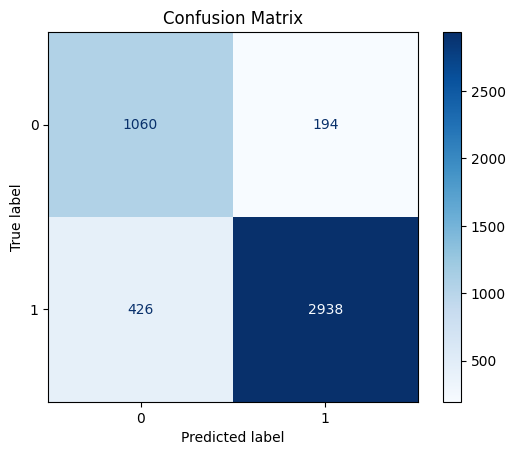

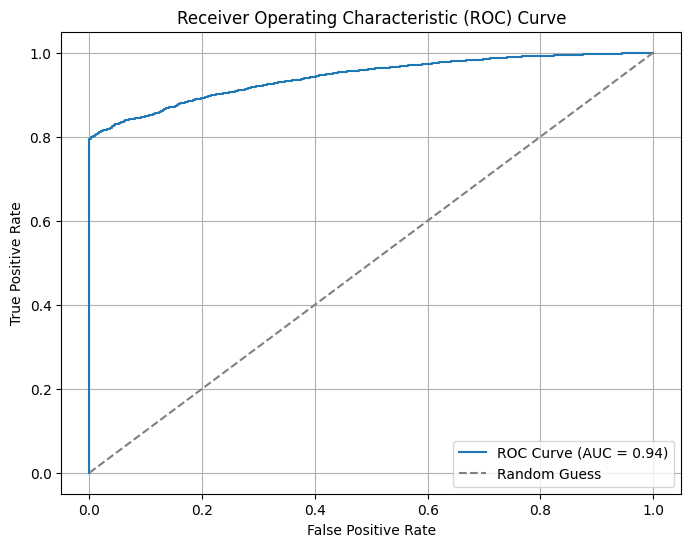

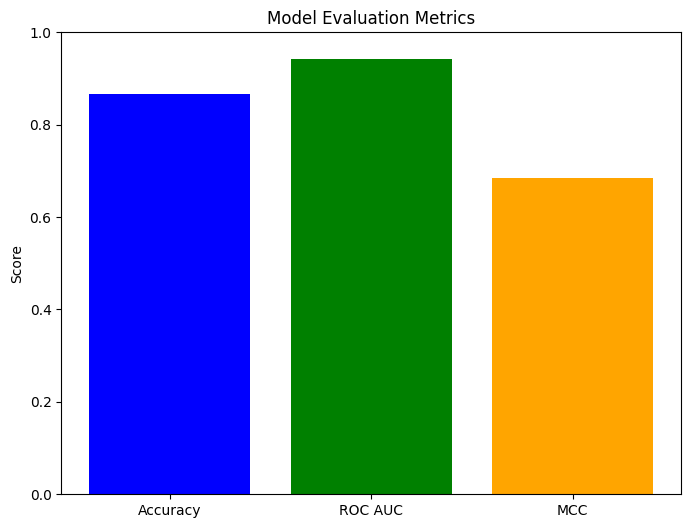

In [254]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    matthews_corrcoef
)


def logistic_regression(target_column, test_size=0.2, random_state=42):
    """
    Implements a logistic regression model using the global adf DataFrame.

    Args:
        target_column (str): The name of the column to use as the target variable.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): The seed used by the random number generator.

    Returns:
        dict: A dictionary containing the model, metrics, and plots.
    """
    global adf  # Ensure the function works with the global adf DataFrame

    if 'adf' not in globals():
        raise NameError("The 'adf' DataFrame is not defined. Please define it before running this function.")

    # Ensure the target column exists
    if target_column not in adf.columns:
        raise ValueError(f"Target column '{target_column}' not found in adf.")

    # Split the data into features and target
    X = adf.drop(columns=[target_column])
    y = adf[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Initialize and train the logistic regression model
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC-ROC: {auc:.2f}")
    print(f"MCC: {mcc:.2f}")

    # Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot Model Evaluation Metrics
    metrics = ["Accuracy", "ROC AUC", "MCC"]
    scores = [accuracy, auc, mcc]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, scores, color=['blue', 'green', 'orange'])
    plt.ylim(0, 1)
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Score")
    plt.show()

    # Return results
    return {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "mcc": mcc,
        "confusion_matrix": conf_matrix,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "roc_curve": (fpr, tpr, thresholds)
    }

# Example usage
# Assuming `adf` is your DataFrame and 'target' is the column name of your target variable
result = logistic_regression(target_column="st90d")

#XGB model
###Binary logistic in xgb is for classification

In [255]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr')
clf_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-aucpr:0.86805
[1]	validation_0-aucpr:0.88604
[2]	validation_0-aucpr:0.88884
[3]	validation_0-aucpr:0.88904
[4]	validation_0-aucpr:0.89457
[5]	validation_0-aucpr:0.89616
[6]	validation_0-aucpr:0.89785
[7]	validation_0-aucpr:0.89839
[8]	validation_0-aucpr:0.90049
[9]	validation_0-aucpr:0.90163
[10]	validation_0-aucpr:0.90251
[11]	validation_0-aucpr:0.90325
[12]	validation_0-aucpr:0.90404
[13]	validation_0-aucpr:0.90479
[14]	validation_0-aucpr:0.90528
[15]	validation_0-aucpr:0.90542
[16]	validation_0-aucpr:0.90565
[17]	validation_0-aucpr:0.90594
[18]	validation_0-aucpr:0.90622
[19]	validation_0-aucpr:0.90722
[20]	validation_0-aucpr:0.90714
[21]	validation_0-aucpr:0.90728
[22]	validation_0-aucpr:0.90736
[23]	validation_0-aucpr:0.90736
[24]	validation_0-aucpr:0.90737
[25]	validation_0-aucpr:0.90772
[26]	validation_0-aucpr:0.90813
[27]	validation_0-aucpr:0.90786
[28]	validation_0-aucpr:0.90776
[29]	validation_0-aucpr:0.90797
[30]	validation_0-aucpr:0.90798
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Using the testing dataset by running the testing dataset down the model and drawing a confusion matrix

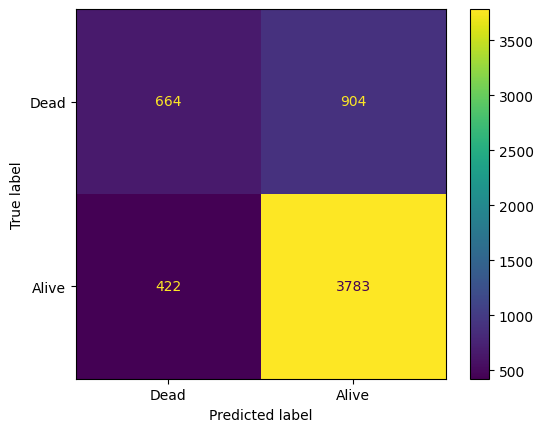

In [256]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dead', 'Alive'])
disp.plot()
plt.show()

#### Confusion matrix has a TP at (0,0), FP(0,1), FN(1,0) and TN(1,1)
plot_confusion_matrix is deprecated and replaced by ConfusionMatrixDisplay.
There is still some inconsistency with our model, Lets use scale_pos_weight to help with imbalanced data. Lets use Cross Validation to optimize parameters

#### Optimizing Parameters using Cross Validation and Grid Search()

XGBoost has a lot of parameters, such as max_depth which is maximum tree depth, learning_rate or eta (gamma) the parameter that encourages pruning and reg_lambda the regularization parameter


Since we have too many parameters we will use GridSearchCV(). It will test all the parameters that we tell it to

In [257]:
#fine tuning
#NB TAKES A LOOOT OT TIME
#may fail because of too much ram usage
#to recalibrate every time the feature changes

def optimize_xgboost_params(X, y, param_grid, cv_folds=5, scoring='accuracy'):
    """
    Optimize XGBoost parameters using GridSearchCV and cross-validation.

    Args:
        X (pd.DataFrame or np.array): Features for training.
        y (pd.Series or np.array): Target labels.
        param_grid (dict): Parameter grid for GridSearchCV.
        cv_folds (int): Number of folds for cross-validation (default is 5).
        scoring (str): Scoring metric for GridSearchCV (default is 'accuracy').

    Returns:
        best_model: The best XGBoost model from GridSearchCV.
        best_params: The best parameters from GridSearchCV.
    """
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True)

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    return best_model, best_params

# Step 2: Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Step 3: Optimize parameters
#best_model, best_params = optimize_xgboost_params(X_train, y_train, param_grid)

# Step 4: Evaluate the optimized model

#y_pred = best_model.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Test Accuracy:", accuracy)

In [258]:
def tune_xgboost(X, y, cv_folds=5, early_stopping_rounds=50, max_rounds=5):
    """
    Performs step-by-step hyperparameter tuning for an XGBoost model.

    Args:
        X (pd.DataFrame or np.ndarray): Feature matrix.
        y (pd.Series or np.ndarray): Target vector.
        cv_folds (int): Number of cross-validation folds.
        early_stopping_rounds (int): Early stopping rounds for XGBoost.
        max_rounds (int): Maximum number of boosting rounds.

    Returns:
        dict: The optimized hyperparameters.
    """
    def grid_search(params, grid):
        keys = list(grid.keys())
        param_combinations = list(itertools.product(*[grid[k] for k in keys]))
        best_params = None
        best_score = float('inf')

        for comb in param_combinations:
            param_update = dict(zip(keys, comb))
            params.update(param_update)

            # Evaluate with cross-validation
            model = XGBClassifier(**params)  # Avoid passing `use_label_encoder` explicitly
            scores = cross_val_score(model, X, y, cv=cv_folds, scoring='neg_log_loss')
            mean_score = -np.mean(scores)

            if mean_score < best_score:
                best_score = mean_score
                best_params = param_update

        params.update(best_params)
        return best_params

    # Initial parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'learning_rate': 0.1,
        'n_estimators': max_rounds,
        'use_label_encoder': False  # Keep this only in the params dictionary
    }

    # Step 1: Tune max_depth and min_child_weight
    print("Step 1: Tuning max_depth and min_child_weight...")
    step1_grid = {
        'max_depth': list(range(3, 10, 2)),
        'min_child_weight': list(range(1, 6, 2))
    }
    step1_result = grid_search(params, step1_grid)
    print("Step 1 Result:", step1_result)

    # Step 2: Tune gamma
    print("Step 2: Tuning gamma...")
    step2_grid = {
        'gamma': [i / 10.0 for i in range(0, 5)]
    }
    step2_result = grid_search(params, step2_grid)
    print("Step 2 Result:", step2_result)

    # Step 3: Tune subsample and colsample_bytree
    print("Step 3: Tuning subsample and colsample_bytree...")
    step3_grid = {
        'subsample': [i / 10.0 for i in range(6, 10)],
        'colsample_bytree': [i / 10.0 for i in range(6, 10)]
    }
    step3_result = grid_search(params, step3_grid)
    print("Step 3 Result:", step3_result)

    # Step 4: Tune reg_alpha
    print("Step 4: Tuning reg_alpha...")
    step4_grid = {
        'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
    }
    step4_result = grid_search(params, step4_grid)
    print("Step 4 Result:", step4_result)

    print("Final Optimized Parameters:", params)
    return params

# Example usage
# Replace `X` and `y` with the data
#params = tune_xgboost(X_train, y_train)

# Building, Evaluating, Drawing and Interpreting the Optimized XGBoost Model

In [259]:
clf_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0,
    use_label_encoder=False,
    gamma=0.4,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=0.01,
    n_estimators=100)

# Train the model
clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)


[0]	validation_0-logloss:0.58373
[1]	validation_0-logloss:0.58217
[2]	validation_0-logloss:0.58076
[3]	validation_0-logloss:0.57933
[4]	validation_0-logloss:0.57801
[5]	validation_0-logloss:0.57652
[6]	validation_0-logloss:0.57493
[7]	validation_0-logloss:0.57361
[8]	validation_0-logloss:0.57222
[9]	validation_0-logloss:0.57087
[10]	validation_0-logloss:0.56961
[11]	validation_0-logloss:0.56837
[12]	validation_0-logloss:0.56705
[13]	validation_0-logloss:0.56583
[14]	validation_0-logloss:0.56452
[15]	validation_0-logloss:0.56319
[16]	validation_0-logloss:0.56201
[17]	validation_0-logloss:0.56077
[18]	validation_0-logloss:0.55965
[19]	validation_0-logloss:0.55841
[20]	validation_0-logloss:0.55733
[21]	validation_0-logloss:0.55627
[22]	validation_0-logloss:0.55518
[23]	validation_0-logloss:0.55407
[24]	validation_0-logloss:0.55304
[25]	validation_0-logloss:0.55201
[26]	validation_0-logloss:0.55100
[27]	validation_0-logloss:0.55001
[28]	validation_0-logloss:0.54904
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

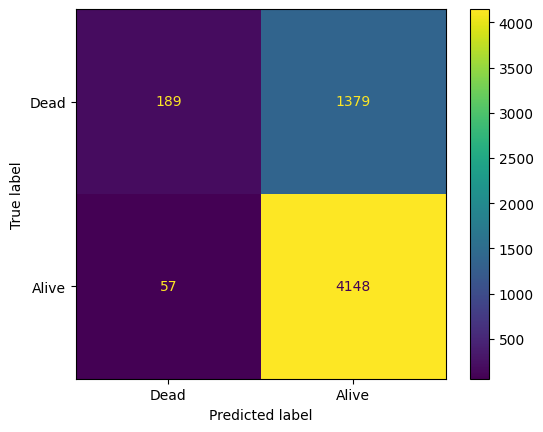

In [260]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dead', 'Alive'])
disp.plot()
plt.savefig('confusion_matrix.png')
plt.show()


##### Drawing an XGBoost Tree

In [265]:
# weight is the number of times a feature is used to split the data across all trees.(no. of times a features is used in a branch or root across all trees)
# gain is the average gain across all splits the feature is used in.
# cover is the average coverage across all splits the feature is used in.
# total_gain is the total gain across all splits the feature is used in.
# total_cover is the total coverage across all splits the feature is used in.

from graphviz import Source

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled',
               'fillcolor': '#e48038'}

graph = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

# Save as PNG
graph.render("xgb_tree", format="png", cleanup=True)

print("Tree graph saved as 'xgb_tree.png'")


weight:  {'respiration': 29.0, 'coagulation': 34.0, 'liver': 28.0, 'cardiovascular': 51.0, 'cns': 93.0, 'renal': 71.0, 'weight': 761.0, 'heart_rate': 436.0, 'sbp': 564.0, 'dbp': 382.0, 'body_temp': 647.0, 'spo2': 463.0, 'resp_rate': 558.0, 'avg_icp': 6.0, 'albumin': 415.0, 'aniongap': 433.0, 'bicarbonate_chem': 251.0, 'bun': 632.0, 'calcium_chem': 227.0, 'chloride_chem': 436.0, 'creatinine_chem': 348.0, 'glucose_chem': 346.0, 'sodium_chem': 453.0, 'potassium_chem': 256.0, 'magnesium_chem': 288.0, 'pt': 279.0, 'ptt': 340.0, 'inr': 237.0, 'bg_lactate': 392.0, 'bg_ph': 253.0, 'bg_so2': 57.0, 'bg_po2': 478.0, 'bg_pco2': 291.0, 'bg_baseexcess': 190.0, 'bg_totalco2': 208.0, 'hematocrit': 216.0, 'hemoglobin': 347.0, 'platelet': 412.0, 'wbc': 315.0, 'NeuC': 235.0, 'sofa_score_2.0': 23.0, 'sofa_score_3.0': 7.0, 'sofa_score_4.0': 1.0, 'sofa_score_5.0': 4.0, 'sofa_score_6.0': 1.0, 'age_78': 1.0, 'age_81': 1.0, 'age_91': 19.0, 'gender_1': 28.0, 'gender_2': 3.0, 'gcs_3.0': 1.0, 'gcs_6.0': 9.0, 'gcs

ROC CURVE

In [273]:
# Assuming X_test and y_test are your test data and labels
y_pred_proba = clf_xgb.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

In [274]:
#generates false positive rate, true positive rate and auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

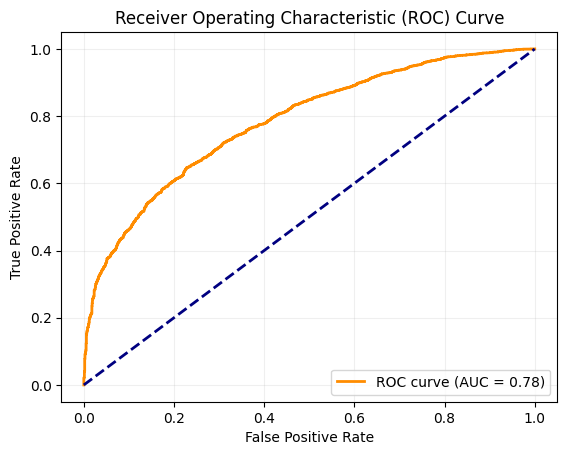

In [275]:
#visualize the roc curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

MCC SCORE

In [276]:
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"MCC: {mcc:.2f}")
print(f"Accuracy: {accuracy:.2f}")

MCC: 0.24
Accuracy: 0.75


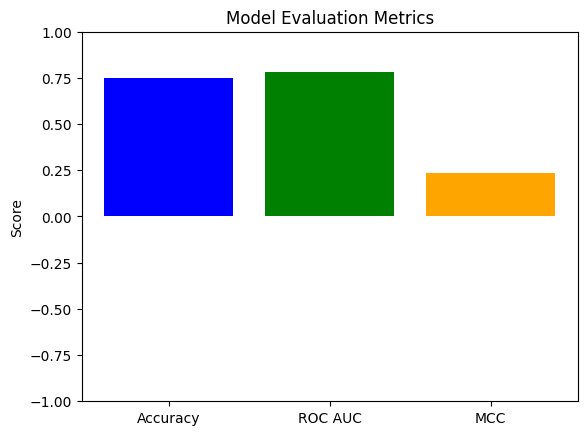

In [277]:
# Visualize metrics
metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'MCC': mcc}
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(-1, 1)  # Adjust limits to accommodate MCC range
plt.show()

#SHAP ANALYSIS OF FEATURES
#analysis of feature importance via shapley

In [278]:
print(X_test.columns)

Index(['respiration', 'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
       'weight', 'heart_rate', 'sbp', 'dbp',
       ...
       'icu_hours_1628', 'icu_hours_1783', 'icu_hours_1802', 'icu_hours_1855',
       'icu_hours_1866', 'icu_hours_1898', 'icu_hours_2072', 'icu_hours_2185',
       'icu_hours_2301', 'icu_hours_2391'],
      dtype='object', length=1052)


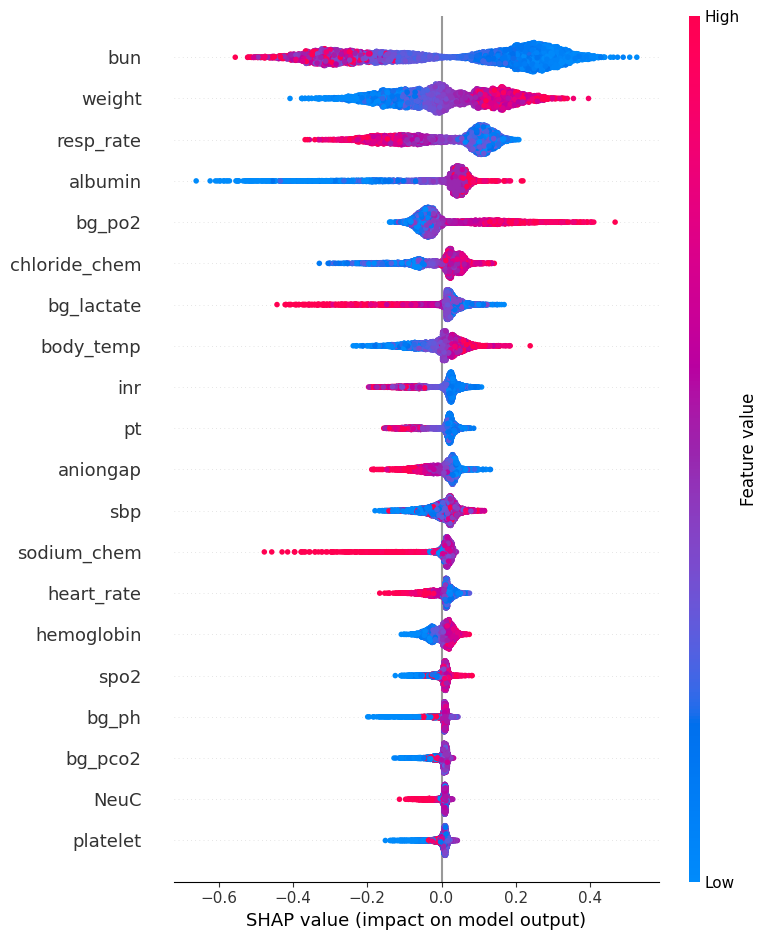

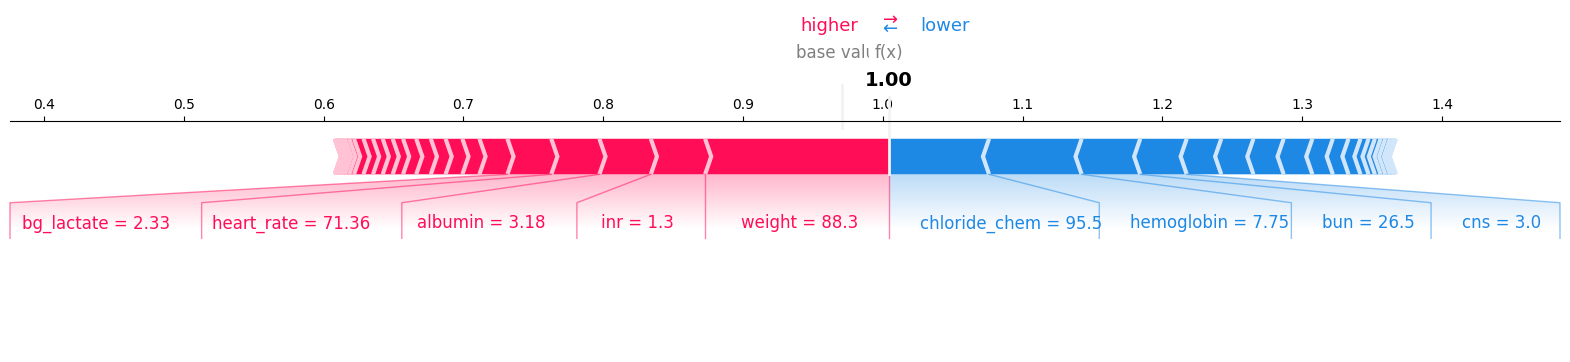

In [272]:
# Step 1: Initialize SHAP TreeExplainer with the trained model
explainer = shap.TreeExplainer(clf_xgb)

# Step 2: Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Step 3: Visualize the summary plot
shap.summary_plot(shap_values, X_test)

# Step 4: Visualize a single prediction with a force plot
# Pick an index to analyze
index = 0  # Choose the index of the sample
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_test.iloc[index],
    matplotlib=True
)

# Step 5: Visualize dependence for a specific feature
# Replace 'feature_name' with the name of the feature to analyze
#shap.dependence_plot('feature_name', shap_values, X_test)